# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


Load Preprocessed Data

In [3]:
X_train = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_train_processed.npy')
X_val = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_val_processed.npy')
X_test = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_test_processed.npy')

y_train = pd.read_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/y_train.csv').values.ravel()
y_val = pd.read_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/y_val.csv').values.ravel()

Helper for Evaluation

In [4]:
def evaluate_model(model, X_val, y_val):
  preds = model.predict(X_val)
  return {
    'accuracy': accuracy_score(y_val, preds),
    'precision': precision_score(y_val, preds),
    'recall': recall_score(y_val, preds),
    'f1': f1_score(y_val, preds)
  }

# Model 1

Train Simple Tree

In [5]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_results = evaluate_model(tree_model, X_val, y_val)
tree_results

{'accuracy': 0.7406555491661875,
 'precision': 0.7502944640753828,
 'recall': 0.7271689497716894,
 'f1': 0.7385507246376811}

Grid Search for Parameters

In [6]:
tree_params = {
  'max_depth': [3, 5, 7, 10, None],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}


tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params,cv=5, scoring='f1', n_jobs=-1)

tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

Best Tree

In [7]:
best_tree = tree_grid.best_estimator_
best_tree_results = evaluate_model(best_tree, X_val, y_val)
best_tree_results

{'accuracy': 0.7918343875790684,
 'precision': 0.7682672233820459,
 'recall': 0.8401826484018264,
 'f1': 0.8026172300981461}

# Model 2

Random Forest

In [8]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_val, y_val)
rf_results

{'accuracy': 0.7952846463484762,
 'precision': 0.8178484107579462,
 'recall': 0.7636986301369864,
 'f1': 0.7898465171192444}

Random Search for Forest

In [9]:
rf_params = {
  'n_estimators': [100, 200, 300],
  'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}


rf_search = RandomizedSearchCV(
  RandomForestClassifier(random_state=42),
  rf_params,
  n_iter=10,
  cv=5,
  scoring='f1',
  n_jobs=-1,
  random_state=42
)


rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1')

Best Forest

In [10]:
best_rf = rf_search.best_estimator_
best_rf_results = evaluate_model(best_rf, X_val, y_val)
best_rf_results

print(best_rf)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)


# Compare Models

In [11]:
results_df = pd.DataFrame([
  {'model': 'Baseline Logistic Regression', 'accuracy': 0.7918, 'precision': 0.7881, 'recall': 0.8025, 'f1': 0.7952},
  {'model': 'Decision Tree', **tree_results},
  {'model': 'Best Decision Tree', **best_tree_results},
  {'model': 'Random Forest', **rf_results},
  {'model': 'Best Random Forest', **best_rf_results}
])

results_df

model  accuracy  precision    recall        f1
0  Baseline Logistic Regression  0.791800   0.788100  0.802500  0.795200
1                 Decision Tree  0.740656   0.750294  0.727169  0.738551
2            Best Decision Tree  0.791834   0.768267  0.840183  0.802617
3                 Random Forest  0.795285   0.817848  0.763699  0.789847
4            Best Random Forest  0.805635   0.811343  0.800228  0.805747

Visualize Comparison

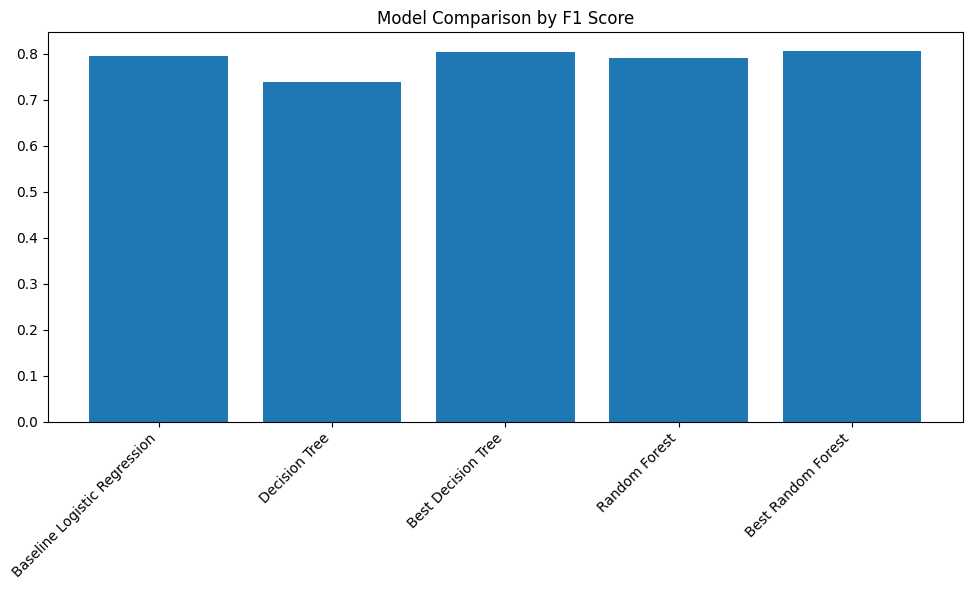

In [12]:
plt.figure(figsize=(10,6))
plt.bar(results_df['model'], results_df['f1'])
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison by F1 Score')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Final_Project_ML_OL/report_images/model_comparison_f1.png')
plt.show()

Best Model

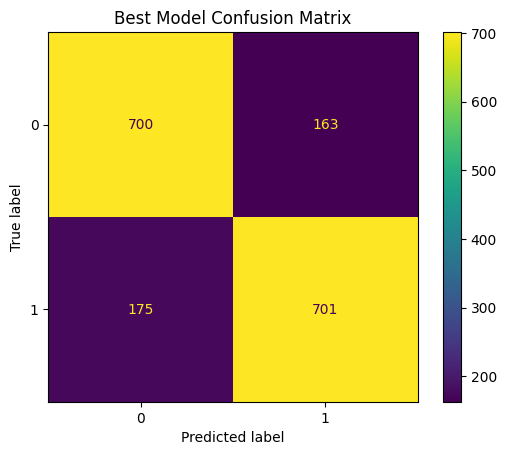

In [13]:
best_model = best_rf
preds = best_model.predict(X_val)
cm = confusion_matrix(y_val, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Best Model Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Final_Project_ML_OL/report_images/best_model_confusion_matrix.png')
plt.show()

pd.DataFrame([best_rf_results]).to_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/best_model_metrics.csv', index=False)

In [15]:
import joblib
import numpy as np
import pandas as pd

MODEL_PATH = "/content/drive/MyDrive/Final_Project_ML_OL/data/final_model.joblib"
PREP_PATH  = "/content/drive/MyDrive/Final_Project_ML_OL/data/preprocessor.joblib"

model = joblib.load(MODEL_PATH)
preprocessor = joblib.load(PREP_PATH)

num_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend','GroupSize']
cat_features = ['HomePlanet','Destination','CabinDeck','CabinSide','CryoSleep','VIP']

def prompt_bool(msg):
    return input(msg + " (y/n): ").strip().lower() in ["y", "yes", "true", "1"]

def split_cabin_single(cabin):
  # returns (CabinDeck, CabinSide) from "G/25/P" etc.
  if cabin is None or (isinstance(cabin, float) and np.isnan(cabin)) or str(cabin).strip() == "":
      return np.nan, np.nan
  parts = str(cabin).split("/")
  deck = parts[0] if len(parts) >= 1 else np.nan
  side = parts[2] if len(parts) >= 3 else np.nan
  return deck, side

def predict_one_from_prompts():
    print("\nEnter passenger info:")
    row = {
        "HomePlanet": input("HomePlanet (Earth/Mars/Europa or blank): ").strip() or np.nan,
        "CryoSleep":  prompt_bool("CryoSleep?"),
        "Cabin":      input("Cabin (e.g., deck/num/side or blank): ").strip() or np.nan,
        "Destination":input("Destination (TRAPPIST-1e/55 Cancri e/PSO J318.5-22 or blank): ").strip() or np.nan,
        "Age":        float(input("Age (number or blank): ").strip() or "nan"),
        "VIP":        prompt_bool("VIP?"),
        "RoomService":float(input("RoomService spend (number): ").strip() or "0"),
        "FoodCourt":  float(input("FoodCourt spend (number): ").strip() or "0"),
        "ShoppingMall":float(input("ShoppingMall spend (number): ").strip() or "0"),
        "Spa":        float(input("Spa spend (number): ").strip() or "0"),
        "VRDeck":     float(input("VRDeck spend (number): ").strip() or "0"),
        "Name":       input("Name (optional; blank ok): ").strip() or np.nan,
        "GroupSize":  int(input("GroupSize (enter a number, default 1): ").strip() or "1"),
    }

    cabin_deck, cabin_side = split_cabin_single(row["Cabin"])
    total_spend = row["RoomService"] + row["FoodCourt"] + row["ShoppingMall"] + row["Spa"] + row["VRDeck"]
    row["CabinDeck"] = cabin_deck
    row["CabinSide"] = cabin_side
    row["TotalSpend"] = total_spend

    X_new_raw = pd.DataFrame([row])[num_features + cat_features]
    X_new = preprocessor.transform(X_new_raw)  # matches your training pipeline

    pred = model.predict(X_new)[0]
    proba = model.predict_proba(X_new)[0] if hasattr(model, "predict_proba") else None

    label = "Transported" if bool(pred) else "Not Transported"
    print("\nPrediction:", label)

    if proba is not None and len(proba) == 2:
        print("Probability Transported:", float(proba[1]))

# Run it:
predict_one_from_prompts()



Enter passenger info:
HomePlanet (Earth/Mars/Europa or blank): Earth
CryoSleep? (y/n): n
Cabin (e.g., deck/num/side or blank): G/44/P
Destination (TRAPPIST-1e/55 Cancri e/PSO J318.5-22 or blank): 55 Cancri e
Age (number or blank): 21
VIP? (y/n): n
RoomService spend (number): 100
FoodCourt spend (number): 100
ShoppingMall spend (number): 100
Spa spend (number): 100
VRDeck spend (number): 100
Name (optional; blank ok): Aidan
GroupSize (enter a number, default 1): 2

Prediction: Not Transported
Probability Transported: 0.19121711319420587


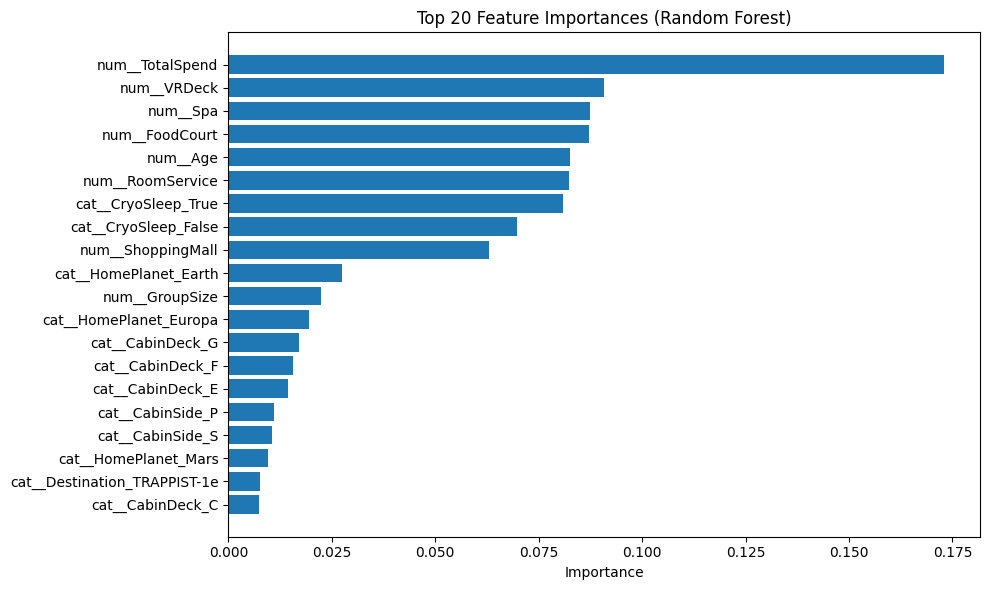

feature  importance
6                  num__TotalSpend    0.172998
5                      num__VRDeck    0.090852
4                         num__Spa    0.087365
2                   num__FoodCourt    0.087245
0                         num__Age    0.082482
1                 num__RoomService    0.082241
25             cat__CryoSleep_True    0.080992
24            cat__CryoSleep_False    0.069811
3                num__ShoppingMall    0.062887
8            cat__HomePlanet_Earth    0.027553
7                   num__GroupSize    0.022279
9           cat__HomePlanet_Europa    0.019425
20                cat__CabinDeck_G    0.016987
19                cat__CabinDeck_F    0.015585
18                cat__CabinDeck_E    0.014482
22                cat__CabinSide_P    0.011065
23                cat__CabinSide_S    0.010432
10            cat__HomePlanet_Mars    0.009648
13    cat__Destination_TRAPPIST-1e    0.007621
16                cat__CabinDeck_C    0.007403
11    cat__Destination_55 Cancri e    0.006783
15                cat__CabinDeck_B    0.005943
12  cat__Destination_PSO J318.5-22    0.003552
17                cat__CabinDeck_D    0.002133
14                cat__CabinDeck_A    0.001251

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model = joblib.load(MODEL_PATH)
# preprocessor = joblib.load(PREP_PATH)

# Get the transformed feature names coming out of your preprocessor
feature_names = preprocessor.get_feature_names_out()

# Random forest impurity-based importances
importances = model.feature_importances_

fi = (pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False))

top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(fi["feature"].head(top_n)[::-1], fi["importance"].head(top_n)[::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Final_Project_ML_OL/report_images/rf_feature_importance_top20.png")
plt.show()

fi.head(25)